In [1]:
# Create circuit to test transpiler on
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import GroverOperator, Diagonal

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2 as Sampler

In [2]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum", token="a46c6e5dba8e93592a0d9d970a427b2fb07ceffe161b81026aab1d8238ef2005eb459b2b858243abff17399633489f2254292f7fdf8d57df99cb32f36f74c819")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

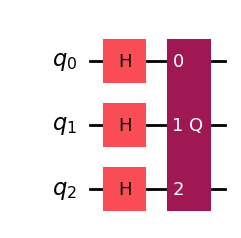

In [3]:
oracle = Diagonal([1] * 7 + [-1])
qc = QuantumCircuit(3)
qc.h([0, 1, 2])
qc = qc.compose(GroverOperator(oracle))

qc.draw(output="mpl", style="iqp")

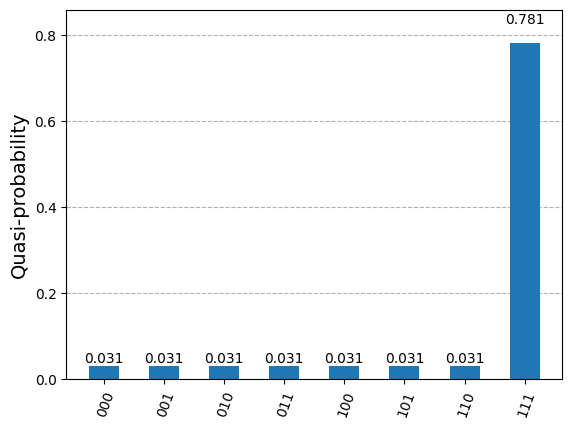

In [4]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()

plot_histogram(ideal_distribution)

In [5]:
# Need to add measurements to the circuit
qc.measure_all()

# Find the correct two-qubit gate
twoQ_gates = set(['ecr', 'cz', 'cx'])
for gate in backend.basis_gates:
    if gate in twoQ_gates:
        twoQ_gate = gate

circuits = []
for optimization_level in [0, 3]:
    pm = generate_preset_pass_manager(optimization_level, backend=backend, seed_transpiler=0)
    t_qc = pm.run(qc)
    print(f"Two-qubit gates (optimization_level={optimization_level}): ", t_qc.count_ops()[twoQ_gate])
    circuits.append(t_qc)

Two-qubit gates (optimization_level=0):  21
Two-qubit gates (optimization_level=3):  14
